In [1]:
import descarteslabs as dl
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
import seaborn as sns
import sys
from tqdm import tqdm

sys.path.append('../')
from scripts.viz_tools import stretch_histogram, normalize, band_descriptions

/Users/ckruse/.envs/plastics/lib/python3.6/site-packages/descarteslabs/client/__init__.py:28: FutureWarning: Support for Python version 3.6 has been deprecated and will be removed in a future version.
  warnings.warn(msg, FutureWarning)


In [2]:
def save_pixel_vectors(data, name, label_class):
    file_name = f"{name}_{START_DATE}_{END_DATE}"
    with open(os.path.join(OUTPUT_DIR, 'pixel_vectors', f"{file_name}_pixel_vectors.pkl"),"wb") as f:
        pickle.dump(data, f)
    with open(os.path.join(OUTPUT_DIR, 'pixel_vectors', f"{file_name}_pixel_vector_labels.pkl"),"wb") as f:
        pickle.dump([label_class] * len(data), f)

In [3]:
sentinel_bands = ['coastal-aerosol',
                  'blue',
                  'green',
                  'red',
                  'red-edge',
                  'red-edge-2',
                  'red-edge-3',
                  'nir',
                  'red-edge-4',
                  'water-vapor',
                  'swir1',
                  'swir2']

In [4]:
geometry_data = '../data/sampling_locations/tpa_polygons.geojson'
with open(geometry_data, 'r') as f:
    polygons = json.load(f)

START_DATE = '2020-01-01'
END_DATE = '2020-12-31'

OUTPUT_DIR = '../data/training_data'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [5]:
cloud_free_images = []

for site in tqdm(polygons['features']):

    cloud_scenes, cloud_geoctx = dl.scenes.search(
        site['geometry'],
        products=["sentinel-2:L1C:dlcloud:v1"],
        start_datetime=START_DATE,
        end_datetime=END_DATE,
    )

    scenes, geoctx = dl.scenes.search(
        site['geometry'],
        products=["sentinel-2:L1C"],
        start_datetime=START_DATE,
        end_datetime=END_DATE
    )

    cloud_stack = cloud_scenes.stack(bands=['valid_cloudfree'],
                                     ctx=geoctx)

    img_stack = scenes.stack(bands=sentinel_bands,
                             ctx=geoctx)

    for img, cloud in zip(img_stack, cloud_stack):
        # Reorder image from channels first to channels last
        img = np.moveaxis(img.data.squeeze(), 0, -1)
        
        # Only save image if cloud fraction is below a threshold
        cloud_fraction = 1 - np.mean(cloud.data[~cloud.mask])
        if cloud_fraction < 0.25:
            cloud_free_images.append(img)
print(f"{len(cloud_free_images):,} images extracted")

100%|██████████| 10/10 [01:26<00:00,  8.70s/it]

325 images extracted


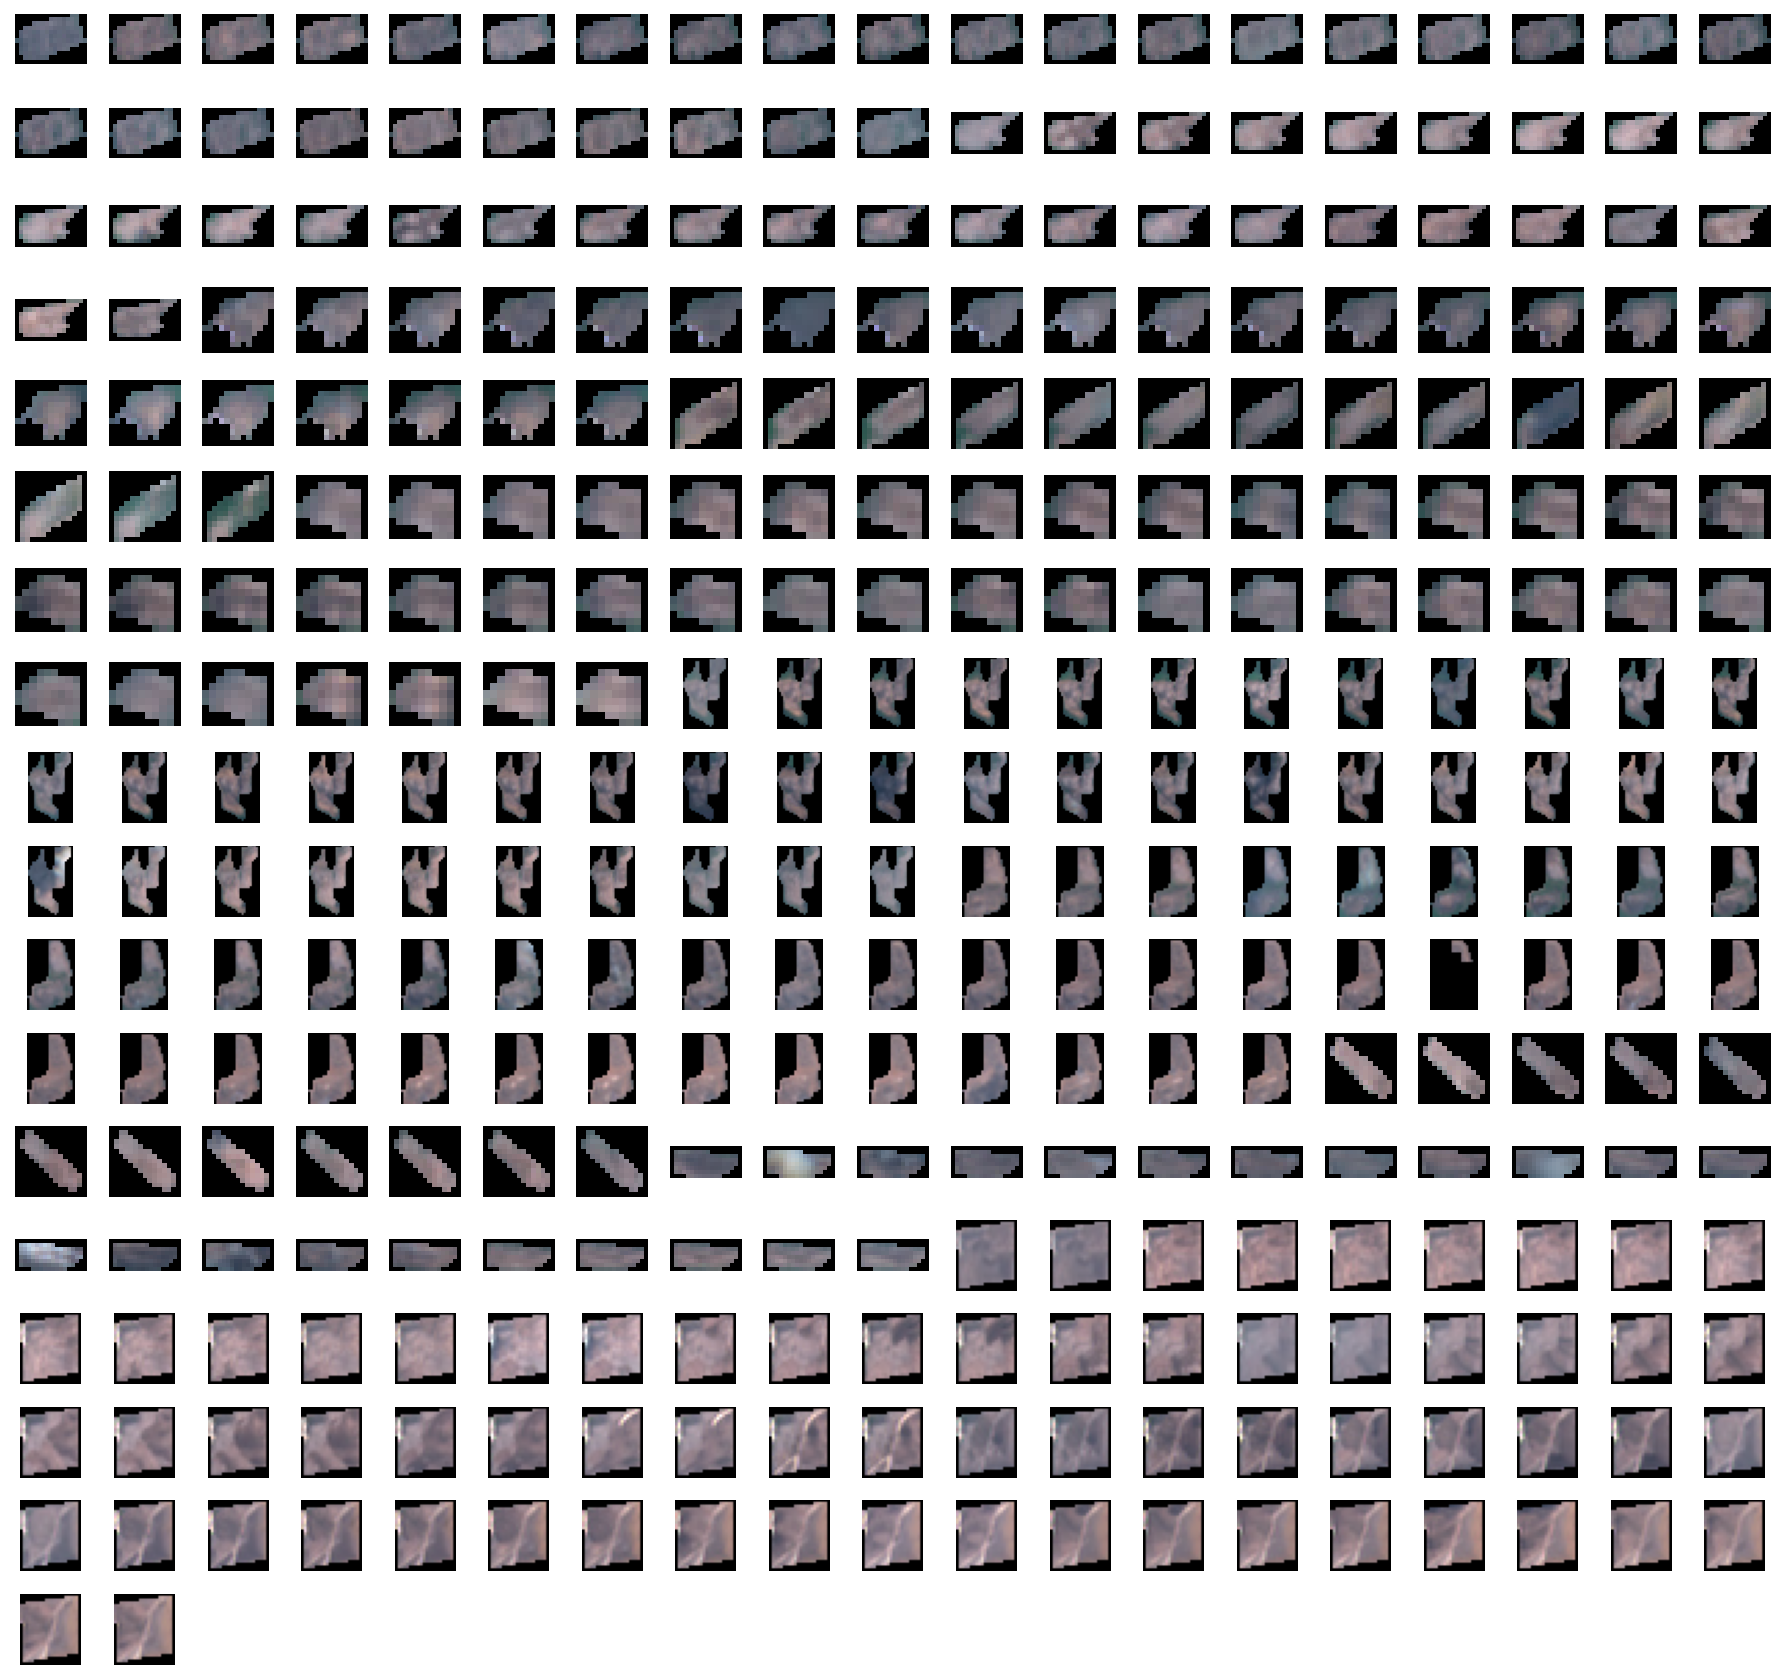

In [6]:
# Plot all extracted images
num_img = int(np.ceil(np.sqrt(len(cloud_free_images))))
plt.figure(figsize=(12, 12), dpi=150)
for index, img in enumerate(cloud_free_images):
    plt.subplot(num_img, num_img, index + 1)
    plt.imshow(np.clip(normalize(img[:,:,3:0:-1]), 0, 1))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
pixel_vectors = []
for img in cloud_free_images:
    height, width, channels = img.shape
    vectors = img.reshape(height * width, channels)
    [pixel_vectors.append(vector) for vector in vectors if np.mean(vector) > 0]
print(f"{np.shape(pixel_vectors)[0]:,} pixel vectors extracted")

72,397 pixel vectors extracted


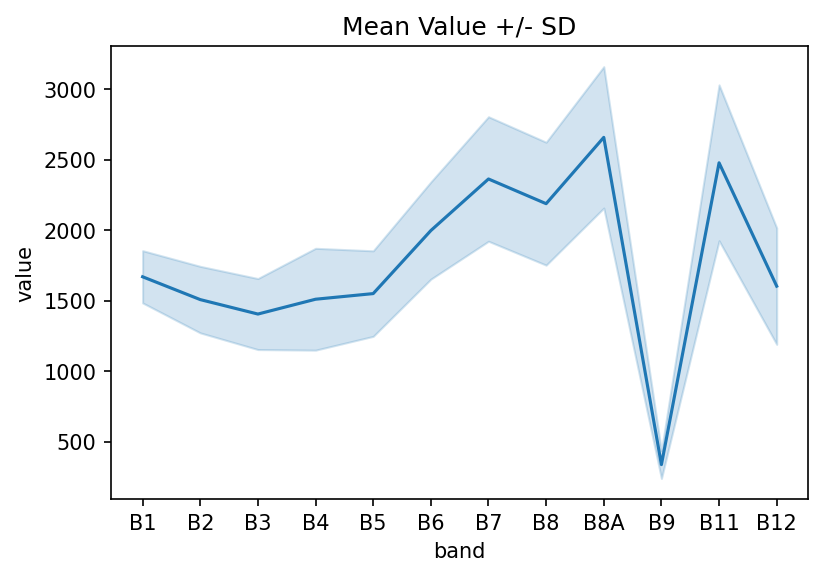

In [8]:
# Plot the mean pixel spectra of the extracted dataset
data = pd.DataFrame(pixel_vectors, columns=band_descriptions.keys()).melt(var_name='band', value_name='value')
plt.figure(figsize=(6,4), dpi=150, facecolor=(1,1,1))
sns.lineplot(x='band', y='value', data=data, ci="sd")
plt.title('Mean Value +/- SD')
plt.show()

In [9]:
save_pixel_vectors(data=pixel_vectors, name='bali_tpa_sites', label_class=1)